In [1]:
import matplotlib.pyplot as plt

import pylab as pl 
import numpy as np 



In [2]:

def trim_edges ( length , delta, Lx,Nx  ) :
    Ly =Lx
    Ny =Nx
    mask = np.ones(Nx*Ny)
    xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
    yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny
    mask[np.where(xarr.flatten() < Lx / length)] = 0
    mask[np.where(xarr.flatten() > (delta) * Lx / length)] = 0
    mask[np.where(yarr.flatten() < Ly / length )] = 0
    mask[np.where(yarr.flatten() > delta  * Ly / length)] = 0
    mask = mask.reshape([Ny, Nx])
    return mask

def standardize(x ):
    xresc =  (x - x.mean())/x.std() 
    return xresc


def make_hog_image(image): 
    fd, hog_image = hog(image, orientations=4, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image#_rescaled 

def augment_dataset (arr ) : 
    # augment training   set by flipping the axis
    flipped1 =np.array([  np.flip( p, axis=1)  for p in arr ] )

    flipped0 =np.array([  np.flip( p, axis=0)  for p in arr ] ) 
    return ( np.concatenate((arr,  flipped0,  flipped1  ) ,axis=0 ) )


def minmaxrescale(x, a=0, b=1):
    """
    Performs  a MinMax Rescaling on an array `x` to a generic range :math:`[a,b]`.
    """
    xresc = (b - a) * (x - x.min()) / (x.max() - x.min()) + a
    return xresc
 

def split_without_overlap(xraw, longitudemask ):  
    training = longitudemask [0] 
    validation = longitudemask [1] 
    test = longitudemask [2] 
    return xraw[training], xraw[validation], xraw[test ] 

def preprocess_data(  arr,  split_wo_overlap=False, longitudemask =None , rescale = True  ):  
    if rescale :
        if arr.shape[-1]>1: 
            for i in range(arr.shape[0]): 
                for k in range(arr.shape[-1]) : 
                    arr[i,:,:,k]=minmaxrescale(arr[i,:,:,k], a=-1,b=1 ) 
        else:
            for i in range(arr.shape[0]): 
                arr[i ]=minmaxrescale(arr[i ], a=-1,b=1 ) 
    if  split_wo_overlap and longitudemask is not None  :
        xtrain, xval,xtest =split_without_overlap  (arr , longitudemask  ) 
    elif  split_wo_overlap and longitudemask is   None  :
        raise ValueError (f'longitudemask is set to {longitudemask}, must be an array to split the data ')
    else :
        xtrain, xval,xtest =split_trainvaltest_sets(arr  )
    
    return xtrain, xval,xtest  


In [3]:
pixelsize=1.5 ; Nx = 128; length=64; aposize=.1; reso_arcmin=15; deltaell=200

#

Lx = np.radians( pixelsize *Nx /60. ) 

lmin = 5* np.pi/Lx 
lmax= np.pi/np.radians(reso_arcmin/3/60 )
delta= length -1
mask = trim_edges(  length, delta, Lx,Nx  )

In [4]:
dustset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/COM_CompMap_Dust-GNILC-F857_2048_R2.00_15amin_training.npz')['patches']
hiset = pl.log10(pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/NHI_HI4Pi_16amin_nside2048_inpainted_training.npz')['patches'] ) 
longimask = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO//co_ext_longitudinal_splitmask.npy')
dtrset,_,dtset = preprocess_data(dustset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
#dtset =augment_dataset(dtset)
htrset,_,htset = preprocess_data(hiset,split_wo_overlap=True, longitudemask=longimask , rescale=False )



In [5]:
coset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO10type2_15amin_nside2048_training.npz')['patches']
cotrset,_,cotset = preprocess_data(coset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
image_test =pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO_cyclegan_predictions.npz') 
copt = image_test['ypred'] [:,:,:,0 ]
Ntest= cotset.shape[0]

In [6]:
import pynkowski as mf 
us = np.arange(-10., 10.01, 0.5) 

dminktest =np.zeros((us.size, Ntest, 3 ) ) 
hminktest  =np.zeros((us.size, Ntest, 3 ) ) 
for i in range(Ntest): 
    data = mf.DataArray( standardize(dtset[i] )  , normalise=True   , mask=None  )     
    dminktest[:,i, 0]  = mf.V0(data, us)
    dminktest[:,i, 1] = mf.V1(data, us)
    dminktest[:,i, 2] = mf.V2(data, us)
    
    data = mf.DataArray( standardize(htset[i] )  , normalise=True   , mask=None  )     
    hminktest[:,i, 0]  = mf.V0(data, us)
    hminktest[:,i, 1] = mf.V1(data, us)
    hminktest[:,i, 2] = mf.V2(data, us)

tqdm not loaded
tqdm not loaded
tqdm not loaded


/global/homes/g/giuspugl/software/namaster_nb/lib/python3.8/site-packages/pynkowski/stats/minkowski.py:170: RuntimeWarning: invalid value encountered in true_divide
  return num / den


In [7]:

minktest =np.zeros((us.size, Ntest, 3 ) ) 
minkpred  =np.zeros((us.size, Ntest, 3 ) ) 
for i in range(Ntest): 
    data = mf.DataArray( standardize(cotset[i] )  , normalise=True   , mask=None  )     
    minktest[:,i, 0]  = mf.V0(data, us)
    minktest[:,i, 1] = mf.V1(data, us)
    minktest[:,i, 2] = mf.V2(data, us)
    
    data = mf.DataArray(  standardize ( minmaxrescale(copt[i], a=cotset[i].min(),b= cotset[i].max()   ))  , normalise=True    , mask=None  ) 
    
    minkpred[:,i,0]   = mf.V0(data, us)
    minkpred[:,i,1] = mf.V1(data, us)
    minkpred[:,i,2] = mf.V2(data, us)


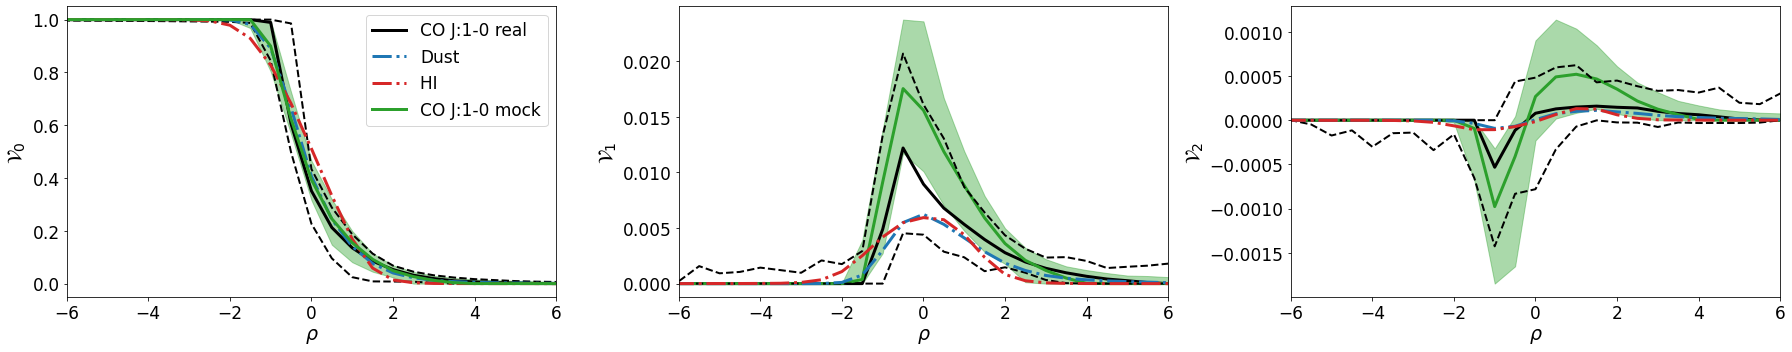

In [8]:
pl.figure(figsize=(25,5 ) ) 
pl.subplot(131)
pl.plot(us,np.median(minktest , axis=1)[:,0]  ,   color='k',linestyle='-' ,lw=3, label='CO J:1-0 real ' ) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,0],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,0],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,0]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,0]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' ) 
pl.plot(us,np.median(minkpred , axis=1)[:,0] ,   color='C2',linestyle='-',lw=3, label='CO J:1-0 mock'  ) 
pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,0] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,0], color='C2', alpha=.4) 

pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_0$', fontsize=20)
pl.yticks(fontsize=17)
pl.legend(fontsize=17) 
pl.subplot(132)
pl.plot(us,np.median(minktest , axis=1)[:,1]  ,   color='k',linestyle='-' ,lw=3) 
pl.plot(us,np.median(minkpred , axis=1)[:,1]  ,   color='C2',linestyle='-' ,lw=3) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,1],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,1],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,1]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,1]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' )  
pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,1] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,1] , color='C2', alpha=.4) 
pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_1$', fontsize=20)
pl.yticks(fontsize=17)
pl.subplot(133)
pl.plot(us,np.median(minktest , axis=1)[:,2]  ,   color='k',linestyle='-',lw=3,  ) 
pl.plot(us,np.median(minkpred , axis=1)[:,2]  ,   color='C2',linestyle='-',lw=3 ) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,2],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,2],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,2]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,2]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' ) 

pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,2] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,2] , color='C2', alpha=.4) 
pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_2$', fontsize=20)
pl.yticks(fontsize=17)
pl.tight_layout () 
pl.savefig('minko10.pdf') 

In [9]:
coset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO21type2_15amin_nside2048_training.npz')['patches']

cotrset,_,cotset = preprocess_data(coset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
copt = image_test['ypred'] [:,:,:,1 ]


minktest =np.zeros((us.size, Ntest, 3 ) ) 
minkpred  =np.zeros((us.size, Ntest, 3 ) ) 
for i in range(Ntest): 
    data = mf.DataArray( standardize(cotset[i] )  , normalise=True   , mask=None  )     
    minktest[:,i, 0]  = mf.V0(data, us)
    minktest[:,i, 1] = mf.V1(data, us)
    minktest[:,i, 2] = mf.V2(data, us)
    
    data = mf.DataArray(  standardize ( minmaxrescale(copt[i], a=cotset[i].min(),b= cotset[i].max()   ))  , normalise=True    , mask=None  ) 
    
    minkpred[:,i,0]   = mf.V0(data, us)
    minkpred[:,i,1] = mf.V1(data, us)
    minkpred[:,i,2] = mf.V2(data, us)

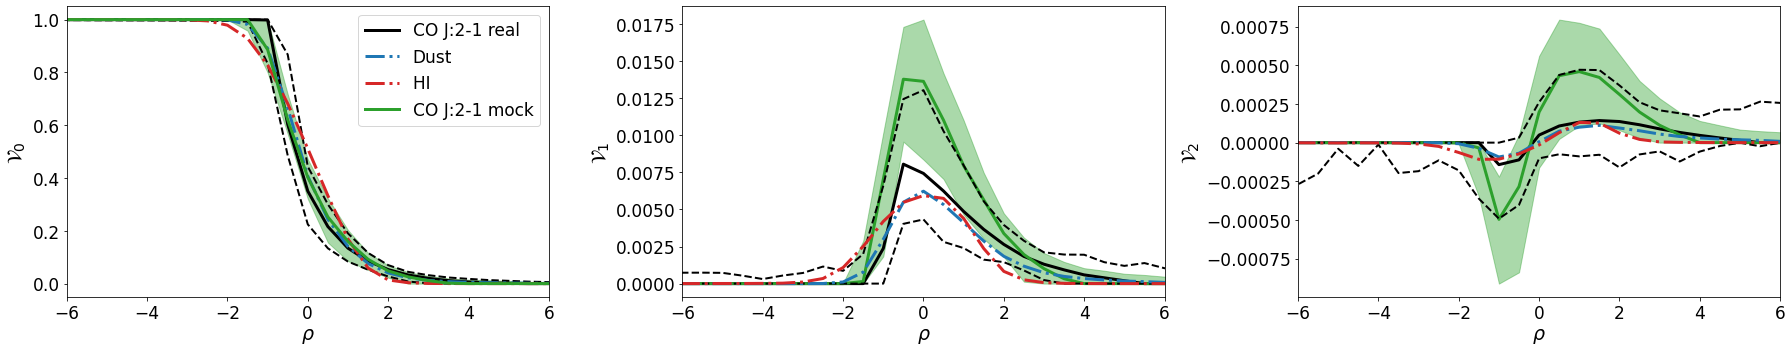

In [10]:
pl.figure(figsize=(25,5 ) ) 
pl.subplot(131)
pl.plot(us,np.median(minktest , axis=1)[:,0]  ,   color='k',linestyle='-' ,lw=3, label='CO J:2-1 real ' ) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,0],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,0],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,0]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,0]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' ) 
pl.plot(us,np.median(minkpred , axis=1)[:,0] ,   color='C2',linestyle='-',lw=3, label='CO J:2-1 mock'  ) 
pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,0] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,0], color='C2', alpha=.4) 

pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_0$', fontsize=20)
pl.yticks(fontsize=17)
pl.legend(fontsize=17) 
pl.subplot(132)
pl.plot(us,np.median(minktest , axis=1)[:,1]  ,   color='k',linestyle='-' ,lw=3) 
pl.plot(us,np.median(minkpred , axis=1)[:,1]  ,   color='C2',linestyle='-' ,lw=3) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,1],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,1],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,1]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,1]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' ) 
pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,1] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,1] , color='C2', alpha=.4) 
pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_1$', fontsize=20)
pl.yticks(fontsize=17)
pl.subplot(133)
pl.plot(us,np.median(minktest , axis=1)[:,2]  ,   color='k',linestyle='-',lw=3,  ) 
pl.plot(us,np.median(minkpred , axis=1)[:,2]  ,   color='C2',linestyle='-',lw=3 ) 
pl.plot(us,np.quantile(q=0.025, a= minktest   ,axis=1)[:,2],   color='k',linestyle='--' ,lw=2.) 
pl.plot(us,np.quantile(q=0.975, a= minktest   ,axis=1)[:,2],   color='k',linestyle='--' ,lw=2., ) 
pl.plot(us,dminktest.mean(axis=1)[:,2]  ,   color='C0',linestyle='-.' ,lw=3, label='Dust' ) 
pl.plot(us,hminktest.mean(axis=1)[:,2]  ,   color='C3',linestyle='-.' ,lw=3, label='HI ' ) 

pl.fill_between( us, np.quantile(q=0.025, a= minkpred  ,axis=1)[:,2] , 
                np.quantile(q=0.975, a= minkpred  ,axis=1)[:,2] , color='C2', alpha=.4) 
pl.xlim(-6,6) 
pl.xlabel(r'$\rho$', fontsize=19)
pl.xticks(fontsize=17)
pl.ylabel(r'$\mathcal{V}_2$', fontsize=20)
pl.yticks(fontsize=17)
pl.tight_layout () 
pl.savefig('minko21.pdf') 